# Imports

In [2]:
import os
import sys

CODE_DIR = "/home/cbarkhof/fall-2021"

sys.path.append(CODE_DIR)
sys.path.append(f"{CODE_DIR}/analysis")
sys.path.append(f"{CODE_DIR}/analysis/bda_models")

PLOT_DIR = f"{CODE_DIR}/analysis/plots/"
PLOT_DIR_BDA_PTB = f"{PLOT_DIR}/PTB_model_checks"
os.makedirs(PLOT_DIR_BDA_PTB, exist_ok=True)

In [3]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import numpyro

# c_cycler, cmap
from plot_utils import *

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

import os
import torch
import pandas as pd

from transformers import RobertaTokenizerFast
import torch.distributions as td

from bda_dp_mixture_surprisal_vals import *
from bda_sequence_length_model_ptb import *

from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

Running on NumPryo v0.8.0


In [4]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/sequence_len_surprisal_values.pt"

SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/sequence_length_surprisal_dp_mixtures.pt"

SAVE_DP_COMP_KL_DISTS_FILE = f"{SAVE_DIR}/sequence_length_dp_mixtures_kl_comp_dists.pt"

LENGTH_DATA_FILE = "ptb_length_analysis_data.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [5]:
PLOT_LENGHTS = True

FIT_AND_COMPUTE_SURPRISAL_VALS = True

PERFORM_MODEL_CHECKS = True

# Load overview of relevant PTB runs

In [6]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
overview_df = overview_df[overview_df.image_or_language == "language"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,100,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."


# Load lengths data and model groups

`ptb_lengths` has key-value structure:
- `data_group`:
    - `train `
    - `valid`
- `modelgroups`:
    - `<run_name>`

In [7]:
if PLOT_LENGHTS or FIT_AND_COMPUTE_SURPRISAL_VALS:
    if os.path.exists(LENGTH_DATA_FILE):
        ptb_lengths = torch.load(LENGTH_DATA_FILE)

        for i in range(len(list(ptb_lengths["model_groups"].values()))):
            for k, v in list(ptb_lengths["model_groups"].values())[i].items():
                print(i, k, len(v))

        for k, v in ptb_lengths["data_group"].items():
            print(k, len(v))
    else:
        print(f"LENGTH_DATA_FILE={LENGTH_DATA_FILE} not found, run preprocess NB first.")

0 condition 2560
0 conditional_sample 2560
0 sample 2000
1 condition 2560
1 conditional_sample 2560
1 sample 2000
2 condition 2560
2 conditional_sample 2560
2 sample 2000
3 condition 2560
3 conditional_sample 2560
3 sample 2000
4 condition 2560
4 conditional_sample 2560
4 sample 2000
5 condition 2560
5 conditional_sample 2560
5 sample 2000
6 condition 2560
6 conditional_sample 2560
6 sample 2000
7 condition 2560
7 conditional_sample 2560
7 sample 2000
8 condition 2560
8 conditional_sample 2560
8 sample 2000
9 condition 2560
9 conditional_sample 2560
9 sample 2000
10 condition 2560
10 conditional_sample 2560
10 sample 2000
11 condition 2560
11 conditional_sample 2560
11 sample 2000
12 condition 2560
12 conditional_sample 2560
12 sample 2000
13 condition 2560
13 conditional_sample 2560
13 sample 2000
14 condition 2560
14 conditional_sample 2560
14 sample 2000
15 condition 2560
15 conditional_sample 2560
15 sample 2000
16 condition 2560
16 conditional_sample 2560
16 sample 2000
17 conditi

# Plot
data group - conditional model samples - unconditional model samples

In [ ]:
# if PLOT_LENGHTS:
#     ncols = 3

#     dataset_name = "PTB"
#     dictionary = ptb_lengths
#     train_data = dictionary["data_group"]["train"]
#     valid_data = dictionary["data_group"]["valid"]

#     hist_kwargs = dict(density=True, lw=0) #bins=62, 

#     for i, (model_name, con_uncon_dict) in enumerate(dictionary["model_groups"].items()):
        
        
#         print(model_name)
#         fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*4, 3))
#         axs[0].hist(train_data, label="train", color=c_dict["orange"], alpha=0.4, **hist_kwargs)
#         axs[0].hist(valid_data, label="valid", color=c_dict["pink"], alpha=0.4,  **hist_kwargs)
#         axs[0].axvline(np.mean(train_data), color=c_dict["orange"])
#         axs[0].axvline(np.mean(valid_data), color=c_dict["pink"])
#         title = f"Data group ({dataset_name.upper()})"
#         title += "\n" + f"min len: {min(train_data + valid_data)} max len: {max(train_data + valid_data)}"
#         axs[0].set_title(title, size=8, y=1.02)

#         col = 1
#         for j, (k, lengths) in enumerate(con_uncon_dict.items()):
#             if k == "condition":
#                 continue
#             axs[col].hist(lengths, color=c_dict["bright_blue"], **hist_kwargs)
#             axs[col].axvline(np.mean(lengths), color=c_dict["bright_blue"])
#             min_len = min(lengths)
#             max_len = max(lengths)
#             #print(min_len, max_len)
#             title = k + "\n" + f"min len: {min_len} max len: {max_len}"
#             axs[col].set_title(title, size=8, y=1.02)
#             axs[col].set_ylim([0, 0.06])
#             axs[col].set_xlim([0, 63])

#             col += 1

#         plt.suptitle(model_name)
#         plt.tight_layout()
#         plt.show()
        
    
if PLOT_LENGHTS:

    dataset_name = "PTB"
    dictionary = ptb_lengths
    train_data = dictionary["data_group"]["train"]
    valid_data = dictionary["data_group"]["valid"]

    hist_kwargs = dict(density=True, lw=1)

    plot_data_titles = ["PTB"]
    plot_data = [[("Train", train_data), ("Valid", valid_data)]]
    for i, (model_name, con_uncon_dict) in enumerate(dictionary["model_groups"].items()):
        model_list = []
        for j, (k, lengths) in enumerate(con_uncon_dict.items()):
            if k == "condition":
                continue
            else:
                stat_name = "Conditional sample" if "condition" in k else "Sample"
                model_list.append((stat_name, lengths))

        plot_data.append(model_list)
        plot_data_titles.append(model_name)

    fig, axs = plt.subplots(ncols=3, nrows=8, figsize=(3*3, 8*1.3))

    for i, (title, stats) in enumerate(zip(plot_data_titles, plot_data)):
        r = i // 3
        c = i % 3

        if "dec:" in title:
            title = title.replace("dec: Strong roBERTa", "")

        if title == "PTB":
            c_0 = c_dict["steal_blue"]
            c_1 = c_dict["bright_blue"]
        else:
            c_0 = c_dict["red"]
            c_1 = c_dict["pink"]

        axs[r, c].hist(stats[0][1], label=stats[0][0], color=c_0, alpha=0.7, **hist_kwargs)
        axs[r, c].axvline(np.mean(stats[0][1]), color=c_0)

        axs[r, c].hist(stats[1][1], label=stats[1][0], color=c_1, alpha=0.4, **hist_kwargs)
        axs[r, c].axvline(np.mean(stats[1][1]), color=c_1)

        axs[r, c].set_title(title, size=8, y=1.02)
        axs[r, c].set_ylim([0, 0.06])
        axs[r, c].set_xlim([0, 63])

        if (r == 0 and c == 0) or (r == 0 and c == 1):
            axs[r, c].legend(loc=(0.0, 1.4))

    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR_BDA_PTB}/sequence_lengths_hists.png", dpi=300, bbox="tight_inches")
    plt.show()

# Conditional sample length versus length conditional

In [8]:
if PLOT_LENGHTS:
    dataset_dict = ptb_lengths
    validation_data = dataset_dict["data_group"]["valid"]

    for model_group, d in ptb_lengths["model_groups"].items():
        print(model_group)
        fig, ax = plt.subplots(figsize=(3, 3))

        model_conditional_validation = d["conditional_sample"][:len(validation_data)]

        ax.scatter(validation_data, model_conditional_validation, alpha=0.1, color="royalblue")
        ax.set_xlabel("data lenght")
        ax.set_ylabel("sampled length")
        ax.set_title(model_group, size=8)
        ax.set_xlim([0, 63])
        ax.set_ylim([0, 63])

        plt.show()

# Fit length model

In [8]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:

    NUM_CHAINS = 1
    NUM_WARMUP = 500
    NUM_SAMPLES = 2000

    # Concat the validation (3370) and the train data (both N = 2000)
    ptb_data = ptb_lengths["data_group"]["valid"] + ptb_lengths["data_group"]["train"]
    type(ptb_data), len(ptb_data), len(ptb_lengths["data_group"]["valid"]), len(ptb_lengths["data_group"]["train"])

    print("Num train + valid samples", len(ptb_data))

    model = GenSeqLenModelPTB(
        ["ptb_train_valid_data"],
        [ptb_data],
        N_valid=len(ptb_lengths["data_group"]["valid"]),
        gamma_shape=[10., 1.9], 
        num_comps=5,
        DP_alpha=0.1, 
        num_chains=NUM_CHAINS, 
        num_warmup=NUM_WARMUP, 
        num_samples=NUM_SAMPLES)
    
    if PERFORM_MODEL_CHECKS:
        print("-"*80)
        print("PRIOR CHECKS")
        prior_samples = model.draw_prior_predictions()
        print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
        _ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30])
        _ = plot_checks(model, prior_samples['y'])
    
    model.run()
    
    if PERFORM_MODEL_CHECKS:
        print("-"*80)
        print("POSTERIOR CHECKS")
        posterior_samples = model.draw_posterior_predictions()
        print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))
        save_posterior_pred_plot = f"{PLOT_DIR_BDA_PTB}/posterior_predictive_check_preds.png"
        _ = plot_predictions(model, posterior_samples['y'], bins=[30, 30], sharex='row', sharey='row', save_as=save_posterior_pred_plot)
        save_posterior_pvals_plot = f"{PLOT_DIR_BDA_PTB}/posterior_predictive_check_pvals.png"
        _ = plot_checks(model, posterior_samples['y'], save_as=save_posterior_pvals_plot)

I0217 16:04:57.076614 22803603042048 tpu_client.py:54] Starting the local TPU driver.
I0217 16:04:57.078194 22803603042048 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0217 16:04:57.079434 22803603042048 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
I0217 16:04:57.080431 22803603042048 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


Num train + valid samples 4560


# Compute surprisal values

In [10]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    surprisal_values = dict()

    local_samples = model.infer_local_assignments(model.posterior_samples, model.y)
    print(tabulate([(k, v.shape) for k, v in local_samples.items()], headers=['rv', 'shape']))

    for i, (model_name, con_uncon_dict) in enumerate(ptb_lengths["model_groups"].items()):
        print(i, model_name)

        conditional_lengths = con_uncon_dict["conditional_sample"]

        unconditional_length = con_uncon_dict["sample"]

        # Estimate log_p_x_y
        cond_cond = - model.estimate_log_p_x_conditional(conditional_lengths, local_samples=local_samples)

        # Estimate log_p_x (returns a numpy array)
        uncond_uncond = - model.estimate_log_p_x(unconditional_length, posterior_samples=model.posterior_samples)

        # Estimate log_p_x (returns a numpy array)
        uncond_cond = - model.estimate_log_p_x(conditional_lengths, posterior_samples=model.posterior_samples)

        surprisal_values[model_name] = dict(
            conditional_conditional=cond_cond, 
            unconditional_unconditional=uncond_uncond,
            unconditional_conditional=uncond_cond
        )

    surprisal_values["data_group"] = {
        "unconditional_unconditional": - model.estimate_log_p_x(ptb_lengths["data_group"]["valid"], posterior_samples=model.posterior_samples),
        "conditional_conditional": - model.estimate_log_p_x_conditional(ptb_lengths["data_group"]["valid"], local_samples=local_samples)
    }
    surprisal_values["data_group"]["unconditional_conditional"] = surprisal_values["data_group"]["unconditional_unconditional"]

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)

else:
    if os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)
    else:
        print(f"SAVE_BDA_SURPRISAL_VALS_FILE={SAVE_BDA_SURPRISAL_VALS_FILE} not found," 
              "run NB with FIT_AND_COMPUTE_SURPRISAL_VALS=True to compute")


rv      shape
------  ------------
z       (2000, 4560)
rate_z  (2000, 4560)
0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
7 INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
8 INFO-VAE l_Rate 1 l_MMD 100 dec: Strong roBERTa
9 INFO-VAE l_Rate 2 l_MMD 1 dec: Strong roBERTa
10 INFO-VAE l_Rate 2 l_MMD 10 dec: Strong roBERTa
11 INFO-VAE l_Rate 2 l_MMD 100 dec: Strong roBERTa
12 BETA-VAE beta 0 dec: Strong roBERTa
13 BETA-VAE beta 0.25 dec: Strong roBERTa
14 BETA-VAE beta 0.5 dec: Strong roBERTa
15 BETA-VAE beta 0.75 dec: Strong roBERTa
16 BETA-VAE beta 1 dec: Strong roBERTa
17 BETA-VAE beta 2 dec: Strong roBERTa
18 FB-VAE 4 dec: Strong roBERTa
19 FB-VAE 8 dec: Strong roBERTa
20 FB-VAE 16 de

I0210 17:13:09.469978 22866877751040 utils.py:145] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0210 17:13:09.471524 22866877751040 utils.py:157] NumExpr defaulting to 8 threads.


Rows: 22, cols: 3, every: 1, n_groups: 22


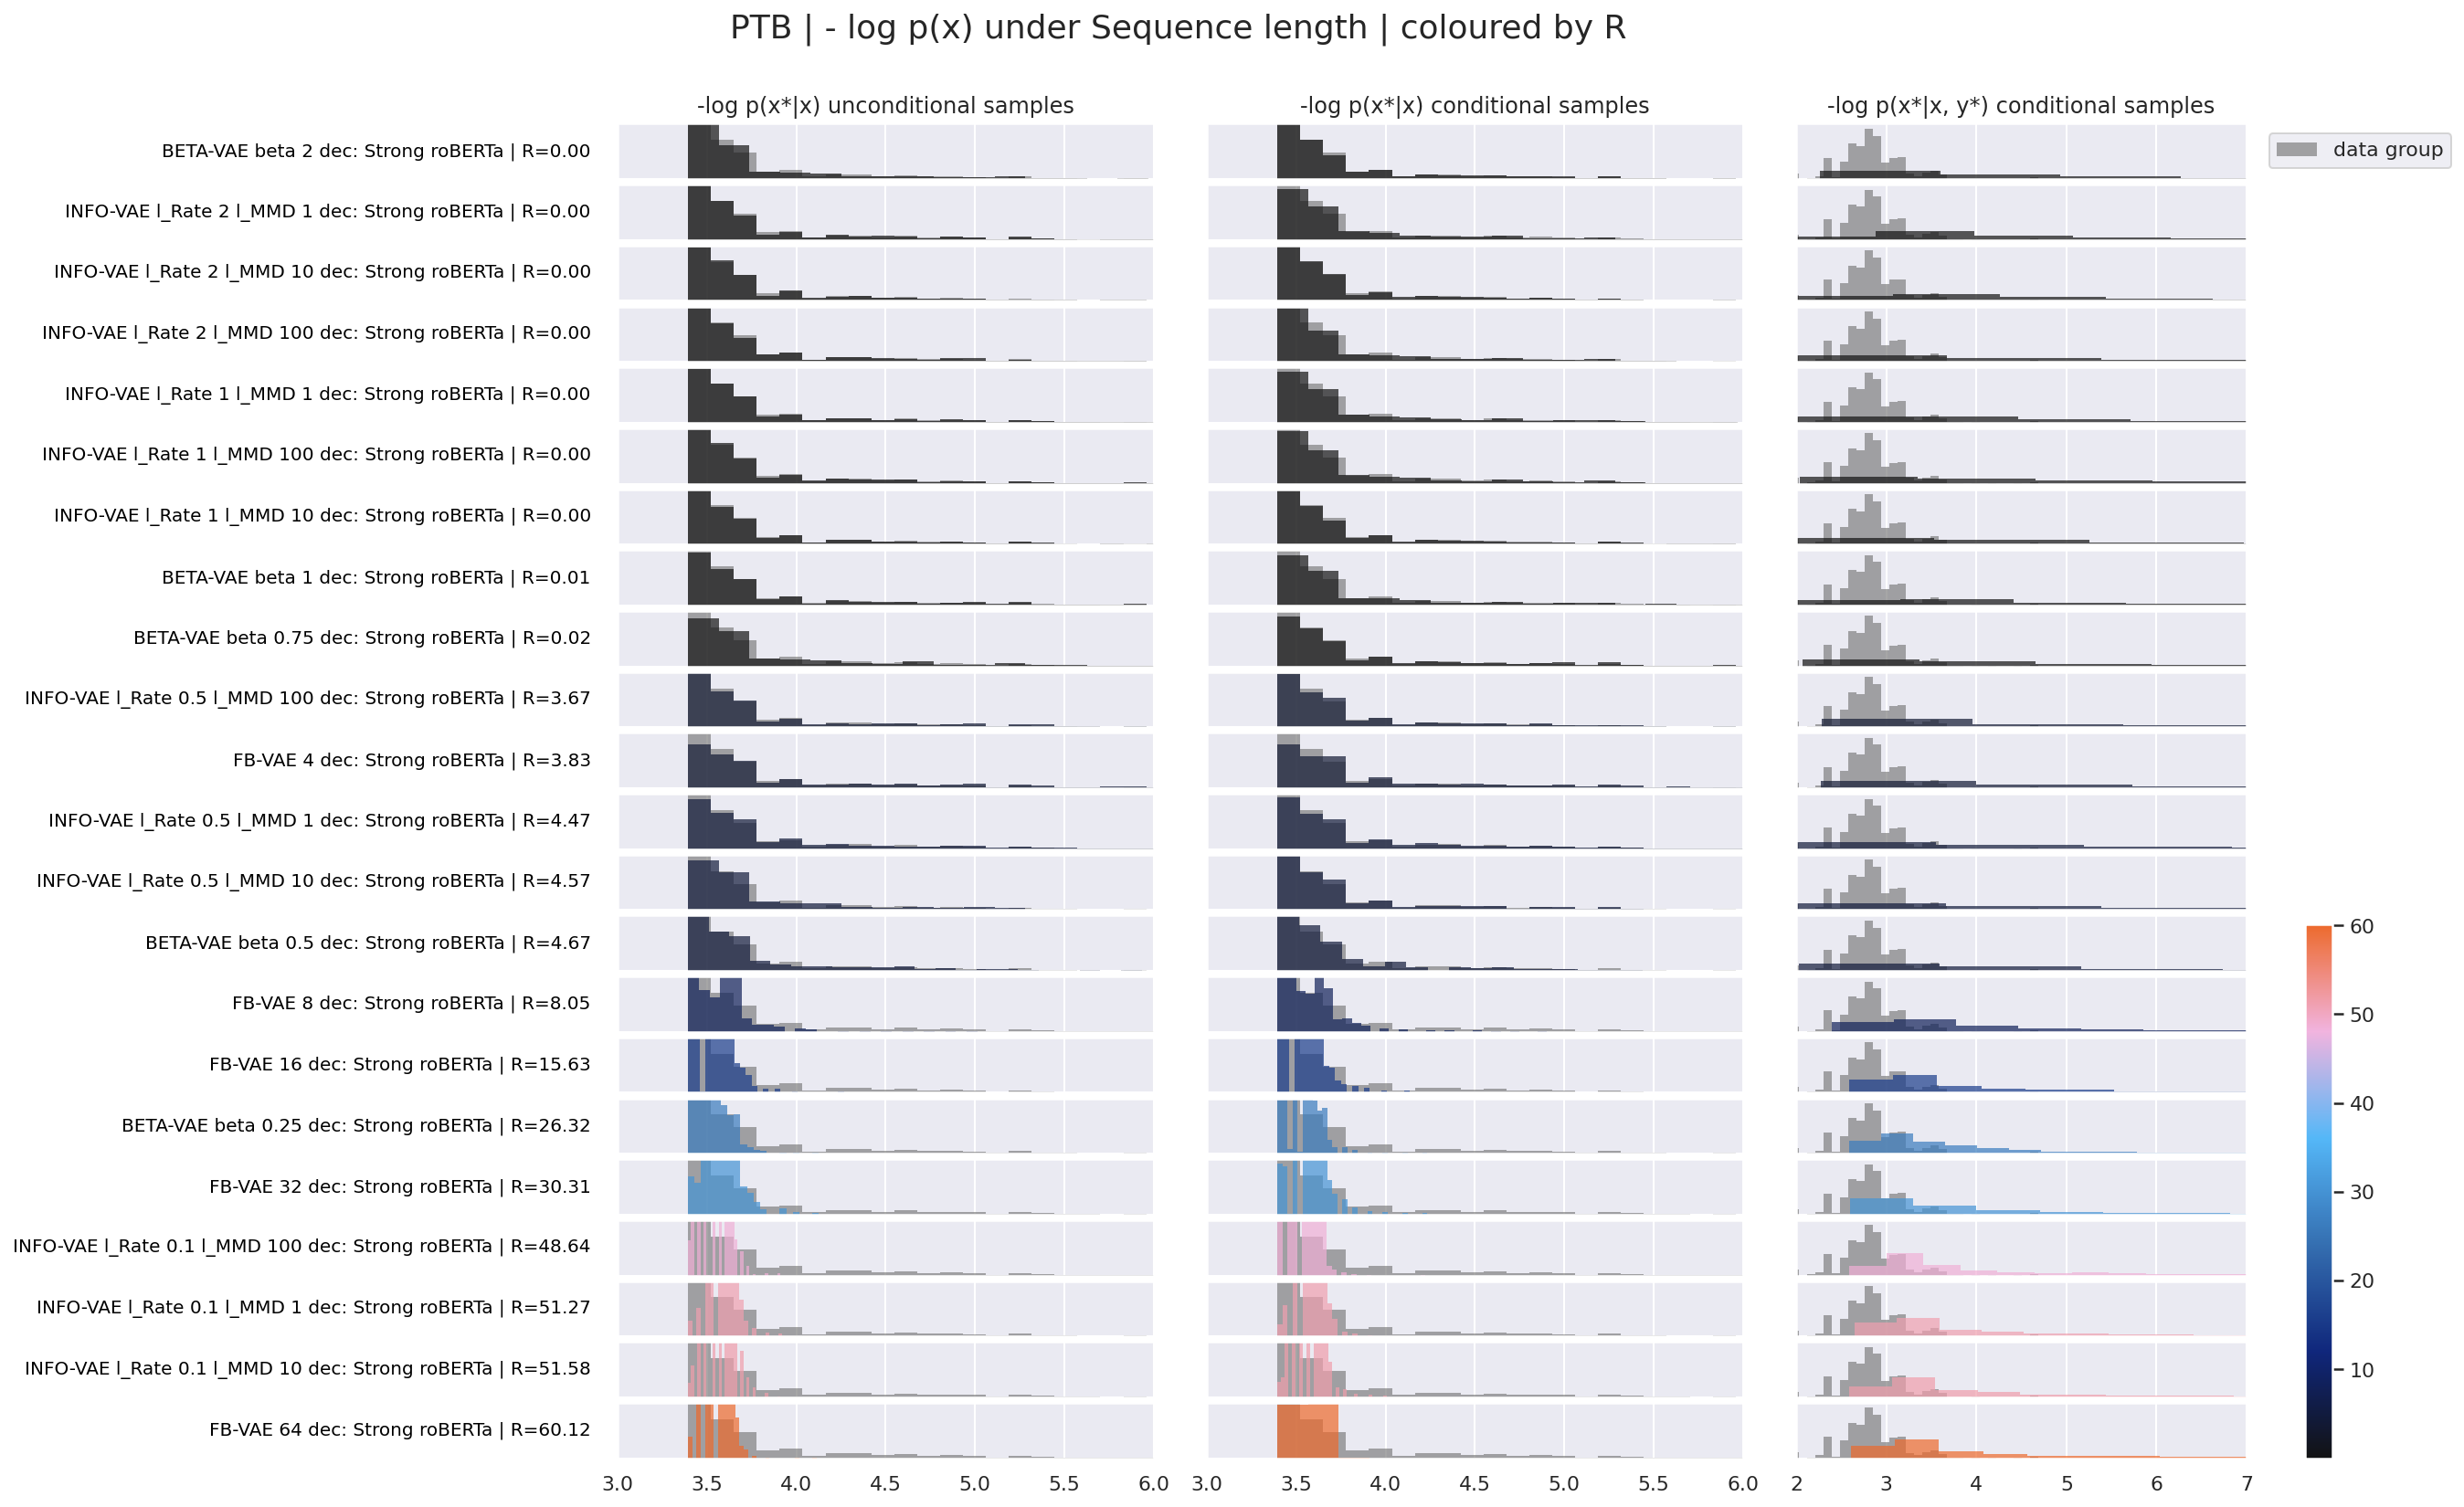

In [11]:
xlims = [[3, 6], [3, 6], [2, 7]]
ylims = [[0, 2.5], [0, 2.5], [0, 2.]]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="Sequence length",
                                         sort_name="R", 
                                         cm_shrink=0.4,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         bins=30,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

Rows: 22, cols: 3, every: 1, n_groups: 22


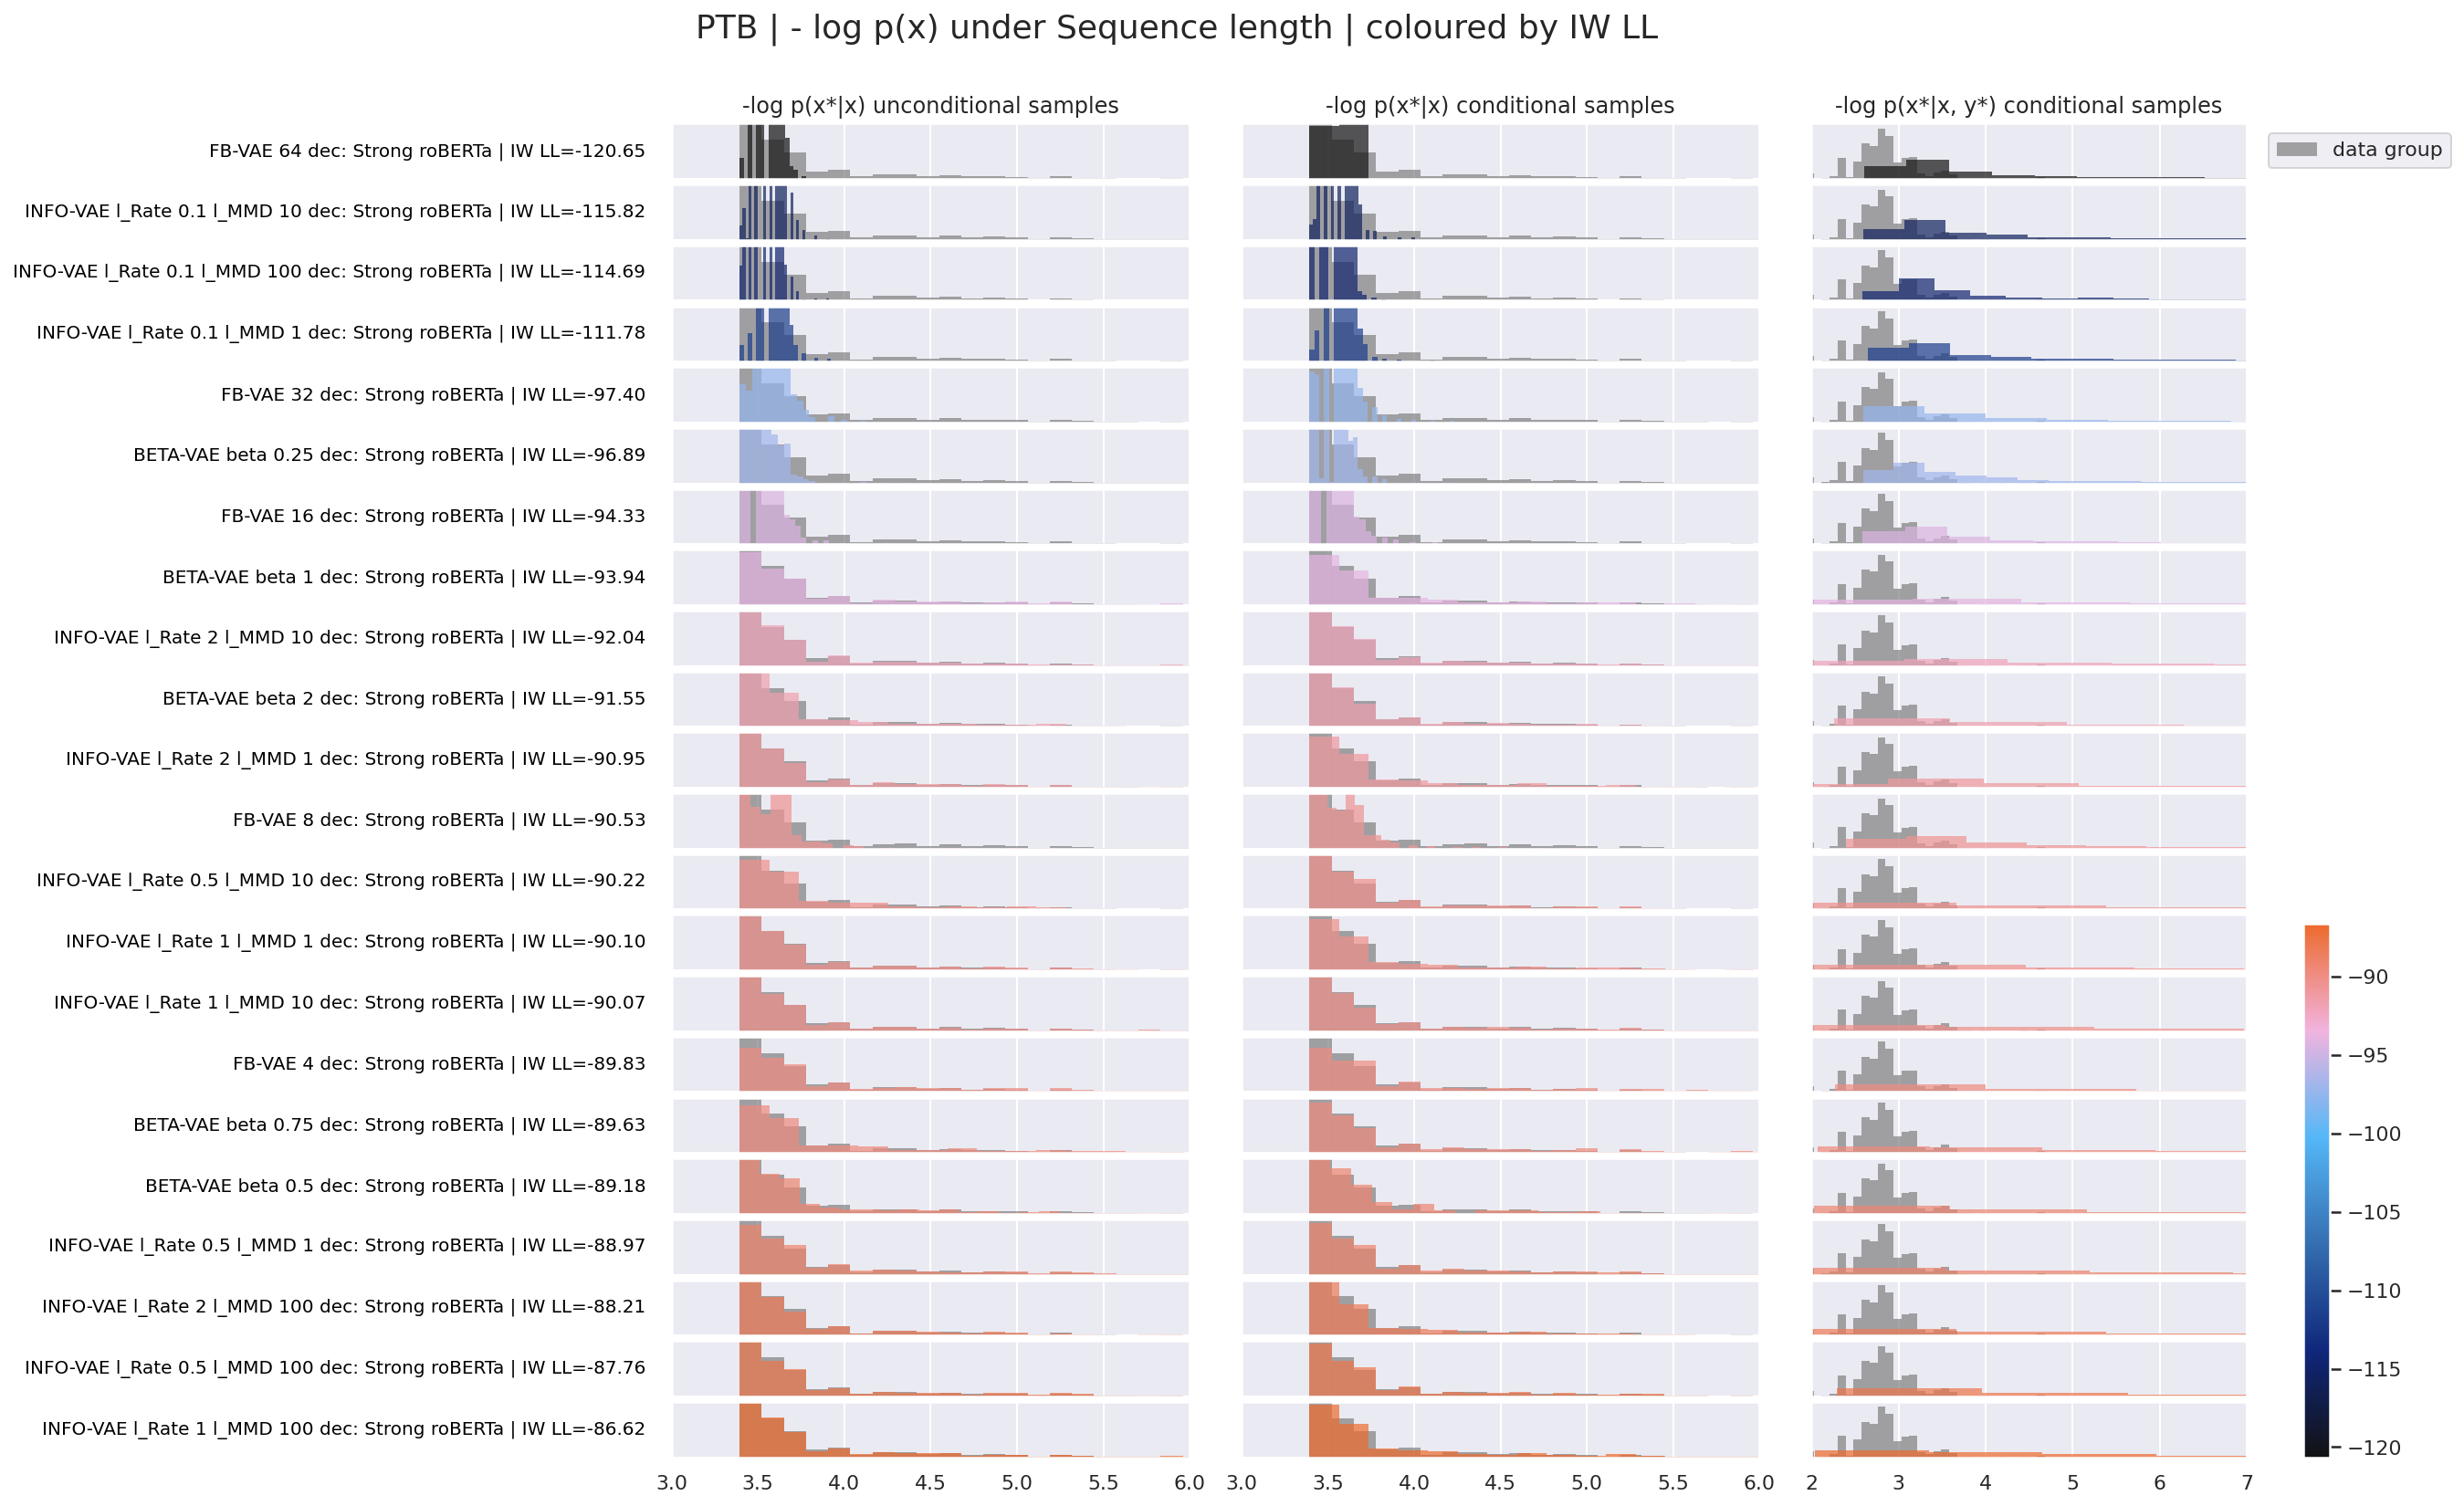

In [12]:
xlims = [[3, 6], [3, 6], [2, 7]]
ylims = [[0, 2.5], [0, 2.5], [0, 2.]]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="PTB",
                                         latent_structure="Sequence length",
                                         sort_name="IW LL", 
                                         cm_shrink=0.4,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         bins=30,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)